<a href="https://colab.research.google.com/github/russodanielp/intro_cheminformatics/blob/google_colab/Lab%2006%20-%20Chemical%20Similarity/colab_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chemical Similarity

## Aim of this lab

To use different similarity metrics and fingerprints to calculate chemical similarity. 

### Objectives

* Calculate chemical similarity
* Retrieve the most similar compounds from a chemical dataset for a target chemical.
* Observe the effects of metrics and feature spaces on molecular similarity. 


## Background

Chemical similarity is a widely used concept in chemistry, drug discovery, and especially cheminformatics.  The chemical similiarity principal states that two molecules that have a similiar structure have similar physicochemical and biological properties.  We know this to be true when we look at the common backbounds or scaffolds that are necessary for binding to a certain receptor or drug target.  Therefore finding similar compounds to a particular chemical of interest is often a widely needed activity in chemistry.  For example, if you had a compound that was a drug and wanted to develop new drugs for that same indication, finding chemicals that look similar to it would be a good place to start. 

But what is similarity? How we define similarity is not necessarily a trivial excercise and is often context dependent.  In fact, the nature of similarity is wholy dependent on how we choose to view or represent certain objects.  Typically when we define chemical similarity it involves two important processes, the similarity function (i.e., the calculation to derive similarity) and the descriptors (i.e., the numerical representation of chemicals such as fingerprints or descriptors).  Often times the metric depends on the descriptors as some are only valid for integers like fingerprints.   

### Metrics

#### Tanimoto/Jaccard Similarity

In this descriptor frames, we can see that the rows represent an indivual molecules and the columns (0 -> 166) are the fragments, each specifying a unique substructure with a 1 denoting the presence and 0 denoting the absence of a fragment.  The entirity of this would be known as a 'fingerprint'.  

Using these fingerprints, we can calculate the similarity between molecules based on the number of shared features.  The most common measure for this is the Tanimoto coeffiecient, also known as the [Jaccard  index](https://en.wikipedia.org/wiki/Jaccard_index).  Mathematicall it is defined as:

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

Where $A$ and $B$ are fingerprints.  Let's calculate the similarity between every molecule in the dataset using.  We can write code for this ourselves, but its always easier (and sometimes faster) to use code already written.  The machine learning library scikit-learn has many useful functions.  Here we can calculate the jaccard distance, with the Jaccard index just being 1-distance.

#### Dice Coeffecient

$$DICE(A,B) = \frac{2{|A \cap B|}}{|A| + |B|}$$


First we need to install rdkit.  

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 10.1 MB/s eta 0:00:00


In [2]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd

Next we'll upload the `drugbank.sdf` file..

In [4]:
drugbank = PandasTools.LoadSDF('drugbank.sdf')
drugbank.head(3)

,GENERIC_NAME,SYNONYMS,JCHEM_LOGP,FORMULA,ALOGPS_SOLUBILITY,JCHEM_BIOAVAILABILITY,ID,ROMol
0,Perfluoro tert-butylcyclohexane,Oxycyte,6.403324,C10F20,4.75e-02 g/l,0.0,,<rdkit.Chem.rdchem.Mol object at 0x7fc807e27c80>
1,Dibromothymoquinone,"2,5-dibromo-3-isopropyl-6-methyl-1,4-benzoquin...",3.654123,C10H10Br2O2,1.32e-01 g/l,1.0,,<rdkit.Chem.rdchem.Mol object at 0x7fc807e270b0>
2,"5-chloro-7-[(1-methylethyl)amino]pyrazolo[1,5-...",nan,1.668743,C10H10ClN5,1.18e-01 g/l,1.0,,<rdkit.Chem.rdchem.Mol object at 0x7fc807e27cf0>


In [5]:
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys


def calc_fp_from_mol(mol, method="maccs", n_bits=1024):
    """
    Encode a molecule from a RDKit Mol into a fingerprint.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    if method == "maccs":
        return MACCSkeys.GenMACCSKeys(mol)
    if method == "ecfp4":
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    if method == "ecfp6":
        return AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits)
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return MACCSkeys.GenMACCSKeys(mol)

How many chemicals are in the drugbank dataset? 

In [6]:
print("There are", drugbank.shape[0], "chemicals in drug bank?")

There are 8357 chemicals in drug bank?


Lets calcuate fingerprints for our drugbank dataset.  We well need to calculate "maccs" and "ecfp6".  We'll use list comprehensions to save time, they're just fancy ways to combine populating a list using a for loop.  

In [7]:
drugbank['maccs'] = [calc_fp_from_mol(mol) for mol in drugbank.ROMol]
drugbank['ecfp6'] = [calc_fp_from_mol(mol, method='ecfp6') for mol in drugbank.ROMol]

Let's find the most similar chemicals in drug bank to Lysergic acid diethylamide (LSD).  The chemical isomeric smiles for LSD is `CCN(CC)C(=O)[C@H]1CN([C@@H]2CC3=CNC4=CC=CC(=C34)C2=C1)C`.

We'll need to calucate `maccs` and `ecfp6` fingerprints for our query, too.  

In [8]:
query_chemical = 'CCN(CC)C(=O)[C@H]1CN([C@@H]2CC3=CNC4=CC=CC(=C34)C2=C1)C'
query_mol = Chem.MolFromSmiles(query_chemical)
query_maccs = calc_fp_from_mol(query_mol)
query_ecfp6 = calc_fp_from_mol(query_mol, method='ecfp6')

We can calculate Tanimoto and Dice in bulk using rdkit.  

We want to make two comparisons:  
1) Tanimoto vs Dice using MACCS  
2) MACCS vs ECFP6 using Tanimoto

In [11]:
from rdkit import DataStructs

drugbank['Tanimoto_maccs'] = DataStructs.BulkTanimotoSimilarity(query_maccs, drugbank['maccs'].values)
drugbank['Dice_maccs'] = DataStructs.BulkDiceSimilarity(query_maccs, drugbank['maccs'].values)
drugbank['Tanimoto_ecfp6'] = DataStructs.BulkDiceSimilarity(query_ecfp6, drugbank['ecfp6'].values)

Let's compare distributions of Tanimoto and and Dice from MACCS keys.  

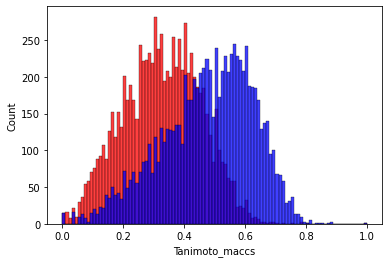

In [12]:
import seaborn as sns

sns.histplot(x=drugbank.Tanimoto_maccs, color='red', bins=100)
sns.histplot(x=drugbank.Dice_maccs, color='blue', bins=100)

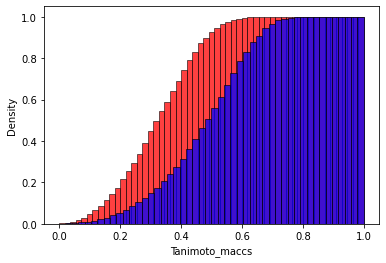

In [13]:
sns.histplot(x=drugbank.Tanimoto_maccs, color='red', cumulative=True, stat="density")
sns.histplot(x=drugbank.Dice_maccs, color='blue', cumulative=True, stat="density")

Let's compare distributions of MACCS and ECFP6 using Tanimoto 

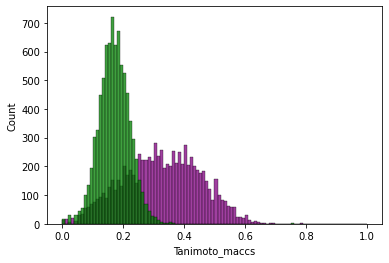

In [14]:
sns.histplot(x=drugbank.Tanimoto_maccs, color='purple', bins=100)
sns.histplot(x=drugbank.Tanimoto_ecfp6, color='green', bins=100)

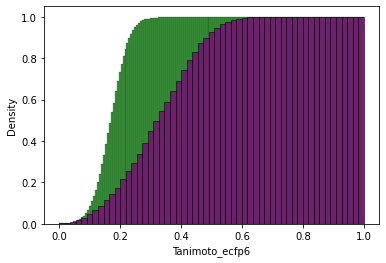

In [15]:
sns.histplot(x=drugbank.Tanimoto_ecfp6, color='green', cumulative=True, stat="density")
sns.histplot(x=drugbank.Tanimoto_maccs, color='purple', cumulative=True, stat="density")

Finally, let's just visualize the top 20 chemicals similar to LSD in DrugBank

In [16]:
top20 = drugbank.sort_values('Tanimoto_maccs', ascending=False).head(20)

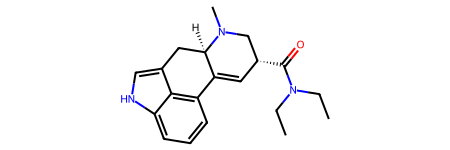

In [17]:
query_mol

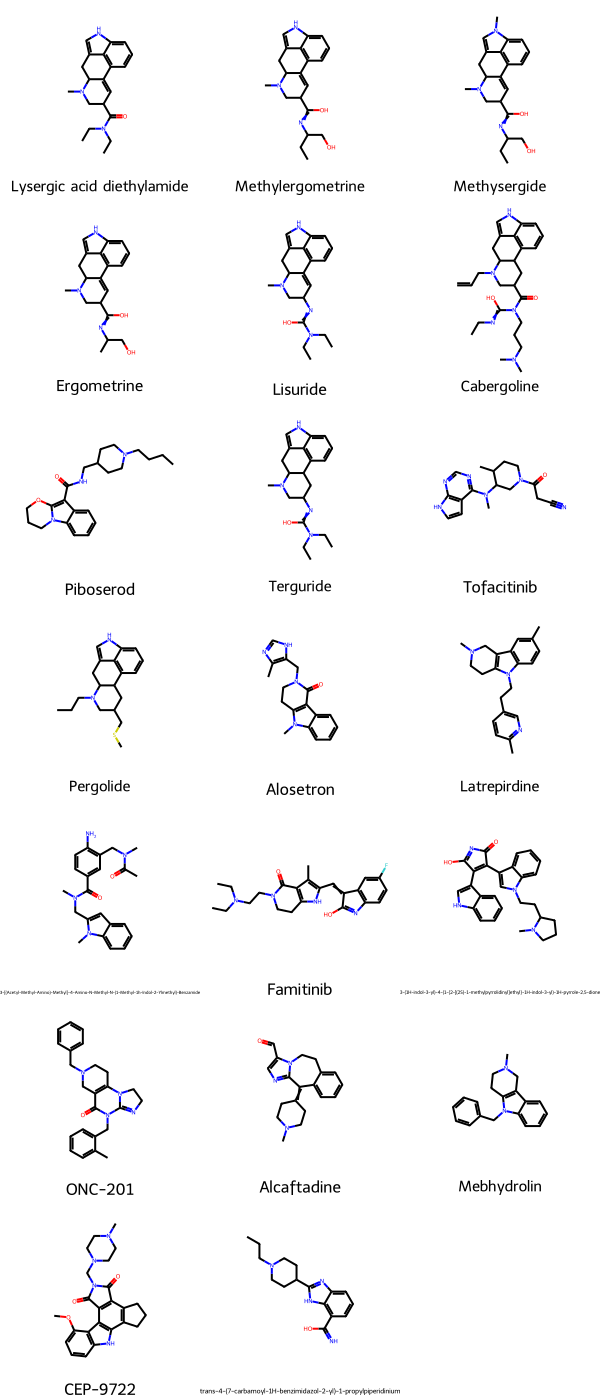

In [18]:
PandasTools.FrameToGridImage(top20, legendsCol='GENERIC_NAME')